> ### **Setup & Data Load**

In [211]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from copy import deepcopy
from sklearn.impute import SimpleImputer

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.grid'] = True

In [212]:
DATA_PATH = "cleaned_EDA_ready_timeseries.csv"
df = pd.read_csv(DATA_PATH)
df

,Country Name,Country Code,Year,GDP_current_usd,Population_total,LifeExp_years,Energy_use_kg_oil_pc,Renewable_energy_pct,CO2_total_mt,CO2_per_capita_ton
0,Albania,ALB,1970,1.578102e+09,2135479.0,65.234,813.373801,25.5,4.8450,2.268812
1,Albania,ALB,1971,1.578102e+09,2187853.0,65.896,813.373801,25.5,4.8381,2.211346
2,Albania,ALB,1972,1.578102e+09,2243126.0,66.526,813.373801,25.5,5.5183,2.460094
3,Albania,ALB,1973,1.578102e+09,2296752.0,67.107,813.373801,25.5,4.9519,2.156045
4,Albania,ALB,1974,1.578102e+09,2350124.0,67.633,813.373801,25.5,5.3296,2.267795
...,...,...,...,...,...,...,...,...,...,...
7825,Zimbabwe,ZWE,2019,2.571566e+10,15271368.0,61.060,412.165419,81.0,11.1692,0.731382
7826,Zimbabwe,ZWE,2020,2.686856e+10,15526888.0,61.530,373.557246,84.1,9.0721,0.584283
7827,Zimbabwe,ZWE,2021,2.724051e+10,15797210.0,60.135,405.518564,82.4,10.6233,0.672480
7828,Zimbabwe,ZWE,2022,3.278966e+10,16069056.0,62.360,416.586875,82.4,10.9630,0.682243


In [213]:
df.columns

Index(['Country Name', 'Country Code', 'Year', 'GDP_current_usd',
       'Population_total', 'LifeExp_years', 'Energy_use_kg_oil_pc',
       'Renewable_energy_pct', 'CO2_total_mt', 'CO2_per_capita_ton'],
      dtype='object')

In [214]:
df.info()
df.describe().T
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7830 entries, 0 to 7829
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Country Name          7830 non-null   object 
 1   Country Code          7830 non-null   object 
 2   Year                  7830 non-null   int64  
 3   GDP_current_usd       7722 non-null   float64
 4   Population_total      7830 non-null   float64
 5   LifeExp_years         7830 non-null   float64
 6   Energy_use_kg_oil_pc  7830 non-null   float64
 7   Renewable_energy_pct  7830 non-null   float64
 8   CO2_total_mt          7722 non-null   float64
 9   CO2_per_capita_ton    7722 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 611.8+ KB


Country Name              0
Country Code              0
Year                      0
GDP_current_usd         108
Population_total          0
LifeExp_years             0
Energy_use_kg_oil_pc      0
Renewable_energy_pct      0
CO2_total_mt            108
CO2_per_capita_ton      108
dtype: int64

In [215]:
# Handle missing GDP
df["GDP_current_usd"] = df["GDP_current_usd"].fillna(df["GDP_current_usd"].median())

# Handle Energy_use anomalies & missing
df.loc[df["Energy_use_kg_oil_pc"] <= 0, "Energy_use_kg_oil_pc"] = np.nan

# Fill missing (median)
df["Energy_use_kg_oil_pc"] = (df.groupby("Country Code")["Energy_use_kg_oil_pc"].transform(lambda s: s.fillna(s.median())))

In [216]:
print(df.isna().sum())

Country Name              0
Country Code              0
Year                      0
GDP_current_usd           0
Population_total          0
LifeExp_years             0
Energy_use_kg_oil_pc      0
Renewable_energy_pct      0
CO2_total_mt            108
CO2_per_capita_ton      108
dtype: int64


In [217]:
df[df["CO2_total_mt"].isna()].groupby("Year")["Country Name"].count()
df[df["CO2_total_mt"].isna()].groupby("Country Name")["Year"].count().sort_values(ascending=False)

Country Name
Curacao    54
Serbia     54
Name: Year, dtype: int64

In [218]:
df = df[~df["Country Name"].isin(["Curacao", "Serbia"])].copy()
df.isna().sum()

Country Name            0
Country Code            0
Year                    0
GDP_current_usd         0
Population_total        0
LifeExp_years           0
Energy_use_kg_oil_pc    0
Renewable_energy_pct    0
CO2_total_mt            0
CO2_per_capita_ton      0
dtype: int64

In [219]:
print('Data Cleaning Summary >>',"Shape", df.shape, "| Years:", f"{df['Year'].min()}–{df['Year'].max()}", "| Countries:", df['Country Name'].nunique())

Data Cleaning Summary >> Shape (7722, 10) | Years: 1970–2023 | Countries: 143


> #### **Feature Engineering**

In [220]:
df = df.copy()
df["log1p_GDP_current_usd"]   = np.log1p(df["GDP_current_usd"])
df["log1p_Population_total"]  = np.log1p(df["Population_total"])
df["log1p_Energy_use_kg_oil_pc"] = np.log1p(df["Energy_use_kg_oil_pc"])
df["log1p_CO2_total_mt"]      = np.log1p(df["CO2_total_mt"])

features = ["log1p_GDP_current_usd","log1p_Population_total","log1p_Energy_use_kg_oil_pc","Renewable_energy_pct","LifeExp_years"]
target = "log1p_CO2_total_mt"

df = df.dropna(subset=features + [target])

## **Modeling & Forecasting**

> ### **Section 1: Statistical Models (Single-Country Pilots)**

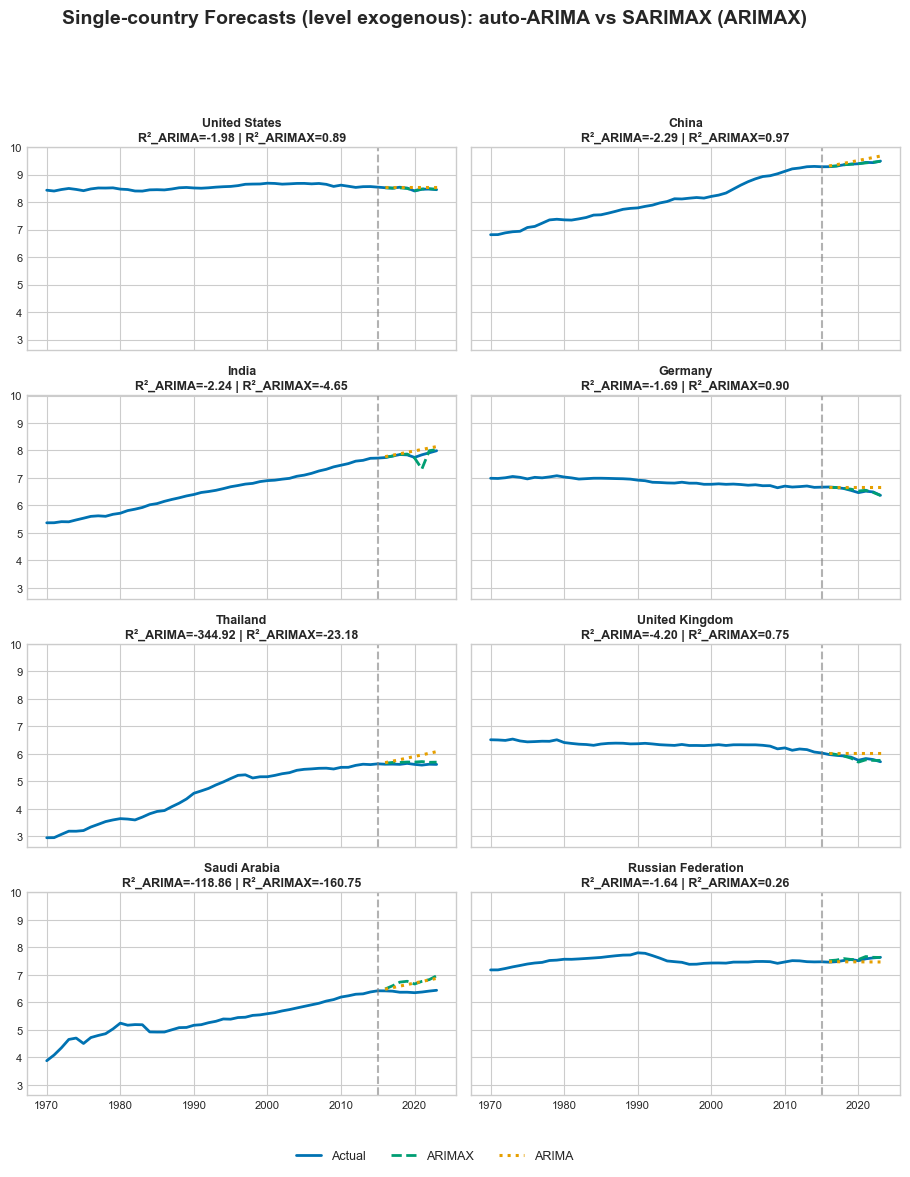

,Country,RMSE_ARIMA,R2_ARIMA,RMSE_ARIMAX,R2_ARIMAX
0,United States,0.071820,-1.978064,0.013636,0.892641
1,China,0.117569,-2.290324,0.010723,0.972629
2,India,0.140076,-2.235809,0.185016,-4.645078
3,Germany,0.157217,-1.686245,0.030716,0.897464
4,Thailand,0.290949,-344.922904,0.076927,-23.182728
5,United Kingdom,0.198206,-4.197525,0.043140,0.753783
6,Saudi Arabia,0.310133,-118.859471,0.360269,-160.745488
7,Russian Federation,0.096553,-1.638009,0.051169,0.259101


In [221]:
target_col = "log1p_CO2_total_mt"
sample_countries = ["United States", "China", "India", "Germany","Thailand", "United Kingdom", "Saudi Arabia", "Russian Federation"]
base_exog_cols = ["log1p_GDP_current_usd","log1p_Energy_use_kg_oil_pc","log1p_Population_total"]
other_exog_cols = ["Renewable_energy_pct","LifeExp_years"]

CUTOFF_SINGLE = 2015 

# growth features are kept for reference; ARIMAX below uses level exog but drops near-constant ones to force signal
df_growth = add_growth_features(df)
exog_cols_levels = base_exog_cols + other_exog_cols

VAR_THRESH = 1e-6


def run_single_country_arima_arimax_enhanced(df,countries=sample_countries,exog_cols=exog_cols_levels,cutoff_year=CUTOFF_SINGLE,target_col=target_col):
    results = []

    fig, axes = plt.subplots(4, 2, figsize=(10, 12),sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, country in zip(axes, countries):
        df_c = (df[df["Country Name"] == country].sort_values("Year").dropna(subset=exog_cols + [target_col]))

        if df_c.empty:
            ax.set_title(f"{country}\n(no data after dropna)", fontsize=9)
            ax.axis("off")
            continue

        train_c = df_c[df_c["Year"] <= cutoff_year]
        test_c  = df_c[df_c["Year"] >  cutoff_year]

        if len(test_c) < 3 or len(train_c) < 15:
            ax.plot(df_c["Year"], df_c[target_col],color="#0072B2", linewidth=2, label="Actual")
            ax.set_title(f"{country}\n(not enough data for test)",fontsize=9, weight="bold")
            continue

        y_train = train_c[target_col].values
        y_test  = test_c[target_col].values

        # drop near-constant exogenous cols to ensure ARIMAX differs
        usable_cols = [c for c in exog_cols if train_c[c].var() > VAR_THRESH]
        if len(usable_cols) == 0:
            print(f"[WARN] {country}: all exog near-constant; ARIMAX falls back to ARIMA")
            X_train = None
            X_test = None
        else:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(train_c[usable_cols])
            X_test  = scaler.transform(test_c[usable_cols])

        # auto-ARIMA (univariate)
        arima_model = auto_arima(
            y_train,
            seasonal=False,
            stepwise=True,
            max_p=6, max_q=6,
            max_order=None,
            n_jobs=-1,
            information_criterion="bic",
            error_action="ignore",
            suppress_warnings=False,
            trace=False)
        y_pred_arima = arima_model.predict(n_periods=len(y_test))

        rmse_arima = np.sqrt(mean_squared_error(y_test, y_pred_arima))
        r2_arima   = r2_score(y_test, y_pred_arima)

        # ARIMAX via SARIMAX with enforced exogenous (if any usable)
        if X_train is None:
            y_pred_arimax = y_pred_arima
            rmse_arimax = rmse_arima
            r2_arimax = r2_arima
        else:
            try:
                sarimax_model = SARIMAX(
                    endog=y_train,
                    exog=X_train,
                    order=(1,0,0),
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                )
                fit_res = sarimax_model.fit(disp=False)
                y_pred_arimax = fit_res.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)
                rmse_arimax = np.sqrt(mean_squared_error(y_test, y_pred_arimax))
                r2_arimax   = r2_score(y_test, y_pred_arimax)
            except Exception as e:
                print(f"[WARN] {country}: SARIMAX failed ({e}); fallback to ARIMA")
                y_pred_arimax = y_pred_arima
                rmse_arimax = rmse_arima
                r2_arimax = r2_arima

        results.append([country,rmse_arima,  r2_arima,rmse_arimax, r2_arimax        ])

        ax.plot(df_c["Year"], df_c[target_col],color="#0072B2", linewidth=2, label="Actual")
        ax.plot(test_c["Year"], y_pred_arimax,"--", color="#009E73", linewidth=2, label="ARIMAX")
        ax.plot(test_c["Year"], y_pred_arima,":",  color="#E69F00", linewidth=2.2, label="ARIMA")
        ax.axvline(cutoff_year, color="gray", linestyle="--", alpha=0.6)
        ax.set_title(f"{country}\nR²_ARIMA={r2_arima:.2f} | R²_ARIMAX={r2_arimax:.2f}",fontsize=9, weight="bold", pad=4)
        ax.tick_params(axis="both", labelsize=8)

    for ax in axes[len(countries):]:
        ax.axis("off")

    fig.suptitle("Single-country Forecasts (level exogenous): auto-ARIMA vs SARIMAX (ARIMAX)",fontsize=14, weight="bold", y=0.98)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels,loc="lower center",ncol=3,fontsize=9,frameon=False,bbox_to_anchor=(0.5, 0.01))

    plt.tight_layout(rect=[0.06, 0.05, 0.98, 0.93])
    plt.show()

    summary = pd.DataFrame(results,columns=["Country","RMSE_ARIMA",  "R2_ARIMA","RMSE_ARIMAX", "R2_ARIMAX"])
    return summary

summary_enhanced = run_single_country_arima_arimax_enhanced(df_growth)
summary_enhanced


> ### **Section 2: Machine Learning Models (Global)**

> **Baseline Model (Naïve Baseline)**

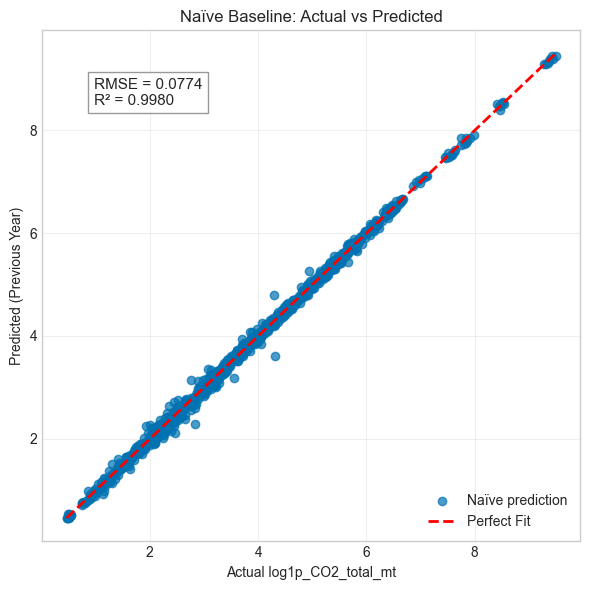

In [222]:
df_naive = df[['Country Code', 'Year', 'log1p_CO2_total_mt']].copy()
df_naive = df_naive.sort_values(['Country Code', 'Year'])
df_naive['prev_CO2'] = df_naive.groupby('Country Code')['log1p_CO2_total_mt'].shift(1)

test_naive = df_naive[df_naive['Year'] > 2015].dropna()
y_true_naive = test_naive['log1p_CO2_total_mt'].values
y_pred_naive = test_naive['prev_CO2'].values

rmse_naive = np.sqrt(mean_squared_error(y_true_naive, y_pred_naive))
r2_naive   = r2_score(y_true_naive, y_pred_naive)

plt.figure(figsize=(6,6))
plt.scatter(y_true_naive, y_pred_naive,alpha=0.7, color="#0072B2",label="Naïve prediction")
plt.plot([y_true_naive.min(), y_true_naive.max()],[y_true_naive.min(), y_true_naive.max()],"r--", linewidth=2, label="Perfect Fit")

plt.xlabel("Actual log1p_CO2_total_mt")
plt.ylabel("Predicted (Previous Year)")
plt.title("Naïve Baseline: Actual vs Predicted")

plt.text(
    x=y_true_naive.min() + 0.5,
    y=y_true_naive.max() - 1.0,
    s=f"RMSE = {rmse_naive:.4f}\nR² = {r2_naive:.4f}",
    fontsize=11,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.8))

plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

> **Baseline Model (Linear Regression)**

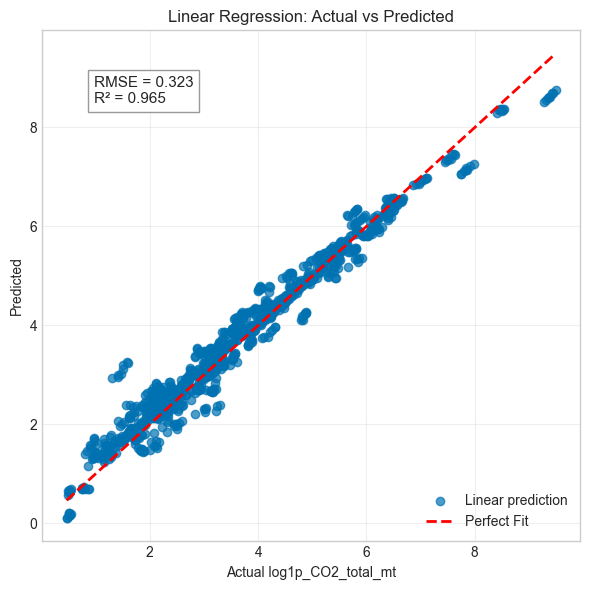

In [223]:
features = ['log1p_GDP_current_usd','log1p_Population_total','log1p_Energy_use_kg_oil_pc','Renewable_energy_pct','LifeExp_years']
target = 'log1p_CO2_total_mt'

CUTOFF_YEAR = 2015
train_df = df[df['Year'] <= CUTOFF_YEAR]
test_df  = df[df['Year'] >  CUTOFF_YEAR]

X_train = train_df[features]
y_train = train_df[target]
X_test  = test_df[features]
y_test  = test_df[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred))
r2_lr = r2_score(y_test, y_pred)


plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7, color="#0072B2",label="Linear prediction")
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],'r--', linewidth=2, label="Perfect Fit") 
plt.xlabel("Actual log1p_CO2_total_mt")
plt.ylabel("Predicted")
plt.title("Linear Regression: Actual vs Predicted")
plt.text(y_test.min()+0.5, y_test.max()-1,f"RMSE = {rmse_lr:.3f}\nR² = {r2_lr:.3f}",fontsize=11,bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

> **Global ML Modeling (Random Forest & XGBoost)**

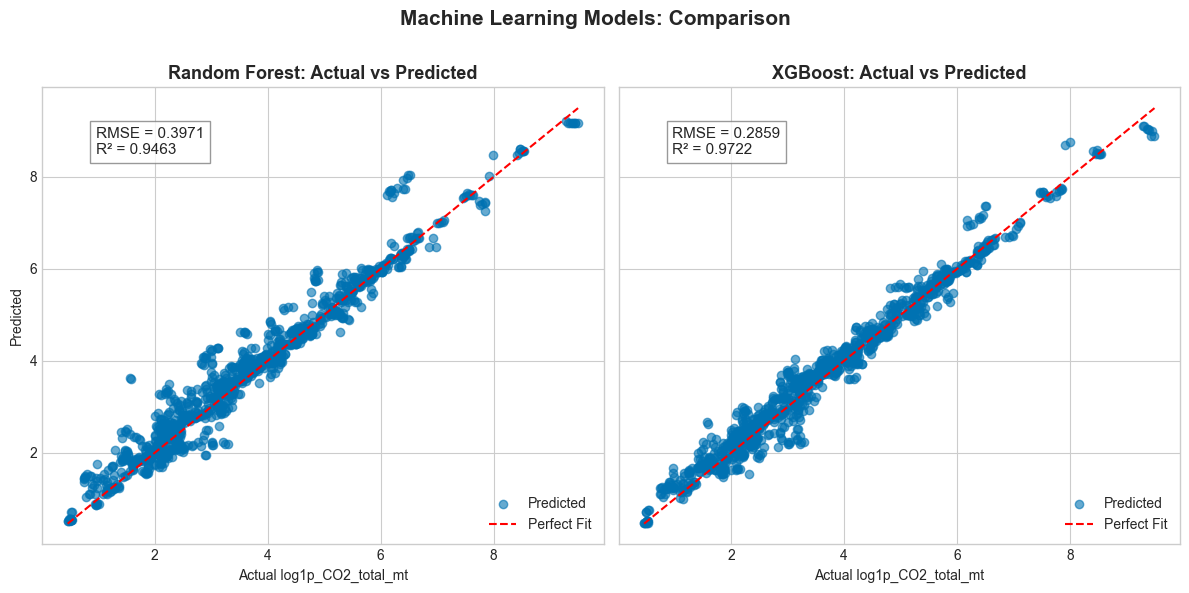

In [224]:
X_train = train_df[features]
y_train = train_df[target]
X_test  = test_df[features]
y_test  = test_df[target]


rf = RandomForestRegressor(n_estimators=300, max_depth=10,min_samples_split=5, min_samples_leaf=3, random_state=42, n_jobs=-1)
xgb = XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=5, subsample=0.8,colsample_bytree=0.8,reg_alpha=0.1,reg_lambda=1.0, random_state=42)

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)


y_pred_rf  = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

def eval_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    return rmse, r2

rf_rmse,  rf_r2  = eval_model(y_test, y_pred_rf)
xgb_rmse, xgb_r2 = eval_model(y_test, y_pred_xgb)

fig, axes = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)

axes[0].scatter(y_test, y_pred_rf, alpha=0.6, color="#0072B2", label="Predicted")
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
axes[0].set_title("Random Forest: Actual vs Predicted", fontsize=13, weight='bold')
axes[0].set_xlabel("Actual log1p_CO2_total_mt")
axes[0].set_ylabel("Predicted")
axes[0].legend(fontsize=10)
axes[0].text(x=y_test.min()+0.5, y=y_test.max()-1.0,s=f"RMSE = {rf_rmse:.4f}\nR² = {rf_r2:.4f}",
    fontsize=11, bbox=dict(facecolor="white", edgecolor="gray", alpha=0.8))

axes[1].scatter(y_test, y_pred_xgb, alpha=0.6, color="#0072B2", label="Predicted")
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
axes[1].set_title("XGBoost: Actual vs Predicted", fontsize=13, weight='bold')
axes[1].set_xlabel("Actual log1p_CO2_total_mt")
axes[1].legend(fontsize=10)
axes[1].text(x=y_test.min()+0.5, y=y_test.max()-1.0,s=f"RMSE = {xgb_rmse:.4f}\nR² = {xgb_r2:.4f}",
    fontsize=11, bbox=dict(facecolor="white", edgecolor="gray", alpha=0.8))

plt.suptitle("Machine Learning Models: Comparison", fontsize=15, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [225]:
y_train_pred_rf  = rf.predict(X_train)
y_train_pred_xgb = xgb.predict(X_train)

def eval_overfit(name, y_train, y_train_pred, y_test, y_test_pred):
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train   = r2_score(y_train, y_train_pred)
    rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test    = r2_score(y_test, y_test_pred)
    print(f"🔍 {name}")
    print(f"  Train → RMSE: {rmse_train:.4f}, R²: {r2_train:.4f}")
    print(f"  Test  → RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}\n")

eval_overfit("Random Forest", y_train, y_train_pred_rf, y_test, y_pred_rf)
eval_overfit("XGBoost", y_train, y_train_pred_xgb, y_test, y_pred_xgb)

🔍 Random Forest
  Train → RMSE: 0.1230, R²: 0.9956
  Test  → RMSE: 0.3971, R²: 0.9463

🔍 XGBoost
  Train → RMSE: 0.1063, R²: 0.9967
  Test  → RMSE: 0.2859, R²: 0.9722



> **Cross-Validation (CV)**

In [226]:
# Panel time-series CV (rolling horizons, no country leakage in time)
cutoff_years = [1995, 2000, 2005, 2010, 2015]
horizons = [1, 3, 5]
ts_cv_rows = []

for cutoff in cutoff_years:
    train = df[df["Year"] <= cutoff].dropna(subset=features + [target])
    for h in horizons:
        test = df[(df["Year"] > cutoff) & (df["Year"] <= cutoff + h)].dropna(subset=features + [target])
        if len(test) == 0 or len(train) < 50:
            continue

        X_train, y_train = train[features], train[target]
        X_test,  y_test  = test[features],  test[target]

        rf = RandomForestRegressor(
            n_estimators=300, max_depth=10,
            min_samples_split=5, min_samples_leaf=3,
            random_state=42, n_jobs=-1)
        xgb = XGBRegressor(
            n_estimators=400, learning_rate=0.05, max_depth=5,
            subsample=0.8, colsample_bytree=0.8,
            reg_alpha=0.1, reg_lambda=1.0,
            random_state=42)

        rf.fit(X_train, y_train)
        xgb.fit(X_train, y_train)

        y_pred_rf  = rf.predict(X_test)
        y_pred_xgb = xgb.predict(X_test)

        rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
        rf_r2   = r2_score(y_test, y_pred_rf)
        xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
        xgb_r2   = r2_score(y_test, y_pred_xgb)

        ts_cv_rows.append([cutoff, h, len(test), rf_rmse, rf_r2, xgb_rmse, xgb_r2])

        print(f"Train <= {cutoff} | Test {cutoff+1}-{cutoff+h} | n={len(test)}")
        print(f"  RF  -> RMSE={rf_rmse:.3f}, R2={rf_r2:.3f}")
        print(f"  XGB -> RMSE={xgb_rmse:.3f}, R2={xgb_r2:.3f}")

if len(ts_cv_rows) == 0:
    ts_cv_results_df = pd.DataFrame(columns=["Cutoff_Year","Horizon","N_test","RF_RMSE","RF_R2","XGB_RMSE","XGB_R2"])
else:
    ts_cv_results_df = pd.DataFrame(ts_cv_rows, columns=["Cutoff_Year","Horizon","N_test","RF_RMSE","RF_R2","XGB_RMSE","XGB_R2"])

ts_cv_results_df


Train <= 1995 | Test 1996-1996 | n=143
  RF  -> RMSE=0.227, R2=0.985
  XGB -> RMSE=0.187, R2=0.990
Train <= 1995 | Test 1996-1998 | n=429
  RF  -> RMSE=0.272, R2=0.978
  XGB -> RMSE=0.228, R2=0.985
Train <= 1995 | Test 1996-2000 | n=715
  RF  -> RMSE=0.282, R2=0.976
  XGB -> RMSE=0.245, R2=0.982
Train <= 2000 | Test 2001-2001 | n=143
  RF  -> RMSE=0.181, R2=0.990
  XGB -> RMSE=0.171, R2=0.991
Train <= 2000 | Test 2001-2003 | n=429
  RF  -> RMSE=0.227, R2=0.984
  XGB -> RMSE=0.209, R2=0.987
Train <= 2000 | Test 2001-2005 | n=715
  RF  -> RMSE=0.280, R2=0.977
  XGB -> RMSE=0.243, R2=0.982
Train <= 2005 | Test 2006-2006 | n=143
  RF  -> RMSE=0.267, R2=0.978
  XGB -> RMSE=0.213, R2=0.986
Train <= 2005 | Test 2006-2008 | n=429
  RF  -> RMSE=0.369, R2=0.959
  XGB -> RMSE=0.276, R2=0.977
Train <= 2005 | Test 2006-2010 | n=715
  RF  -> RMSE=0.423, R2=0.945
  XGB -> RMSE=0.312, R2=0.970
Train <= 2010 | Test 2011-2011 | n=143
  RF  -> RMSE=0.298, R2=0.972
  XGB -> RMSE=0.227, R2=0.984
Train <= 2

,Cutoff_Year,Horizon,N_test,RF_RMSE,RF_R2,XGB_RMSE,XGB_R2
0,1995,1,143,0.227172,0.984981,0.187158,0.989806
1,1995,3,429,0.271818,0.978197,0.228332,0.984615
2,1995,5,715,0.282206,0.976340,0.245225,0.982134
3,2000,1,143,0.181038,0.990131,0.170537,0.991243
4,2000,3,429,0.227368,0.984477,0.208953,0.986889
5,2000,5,715,0.279552,0.976523,0.243082,0.982249
6,2005,1,143,0.266909,0.978468,0.213080,0.986277
7,2005,3,429,0.368992,0.958642,0.276225,0.976823
8,2005,5,715,0.422614,0.945348,0.312237,0.970168
9,2010,1,143,0.297931,0.972248,0.227380,0.983836


In [227]:
if ts_cv_results_df.empty:
    print("No time-series CV results.")
else:
    agg = (ts_cv_results_df.groupby("Horizon")[ ["RF_RMSE","RF_R2","XGB_RMSE","XGB_R2"] ]
                         .mean()
                         .reset_index())
    print("Time-series CV (panel) aggregated by horizon:")
    display(agg)
    display(ts_cv_results_df.head())


Time-series CV (panel) aggregated by horizon:


,Horizon,RF_RMSE,RF_R2,XGB_RMSE,XGB_R2
0,1,0.241750,0.981459,0.198688,0.987688
1,3,0.303006,0.970646,0.239641,0.982011
2,5,0.337932,0.963266,0.265062,0.977837


,Cutoff_Year,Horizon,N_test,RF_RMSE,RF_R2,XGB_RMSE,XGB_R2
0,1995,1,143,0.227172,0.984981,0.187158,0.989806
1,1995,3,429,0.271818,0.978197,0.228332,0.984615
2,1995,5,715,0.282206,0.976340,0.245225,0.982134
3,2000,1,143,0.181038,0.990131,0.170537,0.991243
4,2000,3,429,0.227368,0.984477,0.208953,0.986889


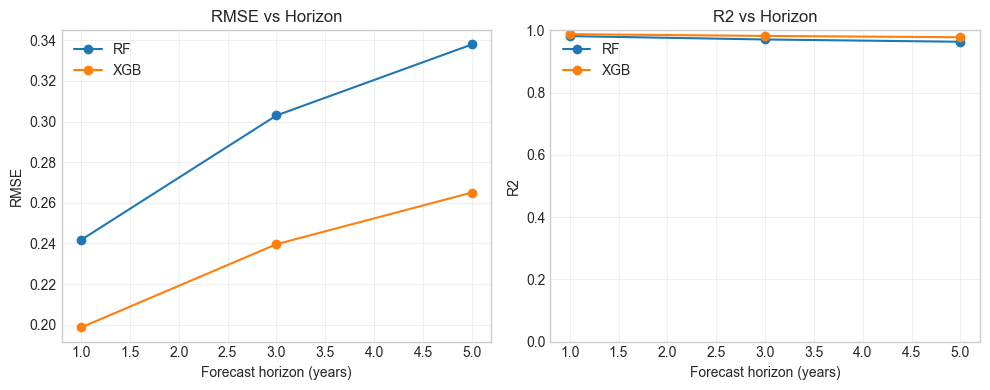

In [228]:
if ts_cv_results_df.empty:
    print("No time-series CV results to plot.")
else:
    agg = (ts_cv_results_df.groupby("Horizon")[ ["RF_RMSE","XGB_RMSE","RF_R2","XGB_R2"] ]
                         .mean()
                         .reset_index())
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    axes[0].plot(agg["Horizon"], agg["RF_RMSE"], "o-", label="RF")
    axes[0].plot(agg["Horizon"], agg["XGB_RMSE"], "o-", label="XGB")
    axes[0].set_xlabel("Forecast horizon (years)")
    axes[0].set_ylabel("RMSE")
    axes[0].set_title("RMSE vs Horizon")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].plot(agg["Horizon"], agg["RF_R2"], "o-", label="RF")
    axes[1].plot(agg["Horizon"], agg["XGB_R2"], "o-", label="XGB")
    axes[1].set_xlabel("Forecast horizon (years)")
    axes[1].set_ylabel("R2")
    axes[1].set_ylim(0,1)
    axes[1].set_title("R2 vs Horizon")
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


### Additional Validation: Country-holdout + Horizon CV
- Hold out a random subset of countries and future years to test robustness across geographies and time.
- Records train vs test metrics to check overfit signs.


In [229]:
cutoff_years_ch = [2005, 2010, 2015]
horizons_ch = [3, 5]
holdout_frac = 0.25
rng = np.random.RandomState(42)
all_countries = sorted(df["Country Code"].unique())
ch_rows = []

for cutoff in cutoff_years_ch:
    for h in horizons_ch:
        holdout_size = max(3, int(holdout_frac * len(all_countries)))
        test_countries = sorted(rng.choice(all_countries, size=holdout_size, replace=False))
        train_countries = [cc for cc in all_countries if cc not in test_countries]

        train = df[(df["Year"] <= cutoff) & (df["Country Code"].isin(train_countries))].dropna(subset=features + [target])
        test  = df[(df["Year"] > cutoff) & (df["Year"] <= cutoff + h) & (df["Country Code"].isin(test_countries))].dropna(subset=features + [target])

        if len(test) < 10 or len(train) < 50:
            print(f"Skip cutoff {cutoff} H={h} (train={len(train)}, test={len(test)})")
            continue

        X_train, y_train = train[features], train[target]
        X_test,  y_test  = test[features],  test[target]

        rf = RandomForestRegressor(
            n_estimators=300, max_depth=10,
            min_samples_split=5, min_samples_leaf=3,
            random_state=42, n_jobs=-1)
        xgb = XGBRegressor(
            n_estimators=400, learning_rate=0.05, max_depth=5,
            subsample=0.8, colsample_bytree=0.8,
            reg_alpha=0.1, reg_lambda=1.0,
            random_state=42)

        rf.fit(X_train, y_train)
        xgb.fit(X_train, y_train)

        # train metrics
        y_train_pred_rf  = rf.predict(X_train)
        y_train_pred_xgb = xgb.predict(X_train)
        rf_rmse_tr = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
        rf_r2_tr   = r2_score(y_train, y_train_pred_rf)
        xgb_rmse_tr = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
        xgb_r2_tr   = r2_score(y_train, y_train_pred_xgb)

        # test metrics
        y_pred_rf  = rf.predict(X_test)
        y_pred_xgb = xgb.predict(X_test)
        rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
        rf_r2   = r2_score(y_test, y_pred_rf)
        xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
        xgb_r2   = r2_score(y_test, y_pred_xgb)

        ch_rows.append([cutoff, h, len(test_countries), len(test),
                        rf_rmse_tr, rf_r2_tr, rf_rmse, rf_r2,
                        xgb_rmse_tr, xgb_r2_tr, xgb_rmse, xgb_r2])

        print(f"Cutoff {cutoff} H={h} | holdout countries={len(test_countries)} test={len(test)}")
        print(f"  RF  train RMSE={rf_rmse_tr:.3f} R2={rf_r2_tr:.3f} | test RMSE={rf_rmse:.3f} R2={rf_r2:.3f}")
        print(f"  XGB train RMSE={xgb_rmse_tr:.3f} R2={xgb_r2_tr:.3f} | test RMSE={xgb_rmse:.3f} R2={xgb_r2:.3f}")

ch_cols = ["Cutoff_Year","Horizon","Holdout_countries","N_test",
           "RF_RMSE_train","RF_R2_train","RF_RMSE_test","RF_R2_test",
           "XGB_RMSE_train","XGB_R2_train","XGB_RMSE_test","XGB_R2_test"]

ch_results_df = pd.DataFrame(ch_rows, columns=ch_cols)
ch_results_df


Cutoff 2005 H=3 | holdout countries=35 test=105
  RF  train RMSE=0.105 R2=0.997 | test RMSE=0.556 R2=0.866
  XGB train RMSE=0.078 R2=0.998 | test RMSE=0.372 R2=0.940
Cutoff 2005 H=5 | holdout countries=35 test=175
  RF  train RMSE=0.109 R2=0.997 | test RMSE=0.622 R2=0.870
  XGB train RMSE=0.083 R2=0.998 | test RMSE=0.575 R2=0.889
Cutoff 2010 H=3 | holdout countries=35 test=105
  RF  train RMSE=0.114 R2=0.996 | test RMSE=0.720 R2=0.831
  XGB train RMSE=0.089 R2=0.998 | test RMSE=0.527 R2=0.909
Cutoff 2010 H=5 | holdout countries=35 test=175
  RF  train RMSE=0.102 R2=0.997 | test RMSE=0.566 R2=0.909
  XGB train RMSE=0.082 R2=0.998 | test RMSE=0.430 R2=0.947
Cutoff 2015 H=3 | holdout countries=35 test=105
  RF  train RMSE=0.118 R2=0.996 | test RMSE=0.713 R2=0.857
  XGB train RMSE=0.087 R2=0.998 | test RMSE=0.552 R2=0.915
Cutoff 2015 H=5 | holdout countries=35 test=175
  RF  train RMSE=0.117 R2=0.996 | test RMSE=0.587 R2=0.838
  XGB train RMSE=0.087 R2=0.998 | test RMSE=0.374 R2=0.934


,Cutoff_Year,Horizon,Holdout_countries,N_test,RF_RMSE_train,RF_R2_train,RF_RMSE_test,RF_R2_test,XGB_RMSE_train,XGB_R2_train,XGB_RMSE_test,XGB_R2_test
0,2005,3,35,105,0.104578,0.997007,0.556415,0.865540,0.077681,0.998348,0.371852,0.939947
1,2005,5,35,175,0.109199,0.996535,0.621708,0.870251,0.082666,0.998014,0.575175,0.888947
2,2010,3,35,105,0.114422,0.996151,0.719841,0.830556,0.088623,0.997691,0.527268,0.909089
3,2010,5,35,175,0.101696,0.996923,0.566273,0.908716,0.081859,0.998007,0.429501,0.947487
4,2015,3,35,105,0.118467,0.995747,0.713152,0.857485,0.087211,0.997695,0.552246,0.914540
5,2015,5,35,175,0.116704,0.996336,0.587194,0.837999,0.087285,0.997950,0.374276,0.934183


In [230]:
if ch_results_df.empty:
    print("No country-holdout CV results.")
else:
    display(ch_results_df.head())
    agg_gap = ch_results_df[["RF_R2_train","RF_R2_test","XGB_R2_train","XGB_R2_test"]].mean().to_frame(name="Mean").T
    print("Mean train/test R2 (to spot overfit):")
    display(agg_gap)


,Cutoff_Year,Horizon,Holdout_countries,N_test,RF_RMSE_train,RF_R2_train,RF_RMSE_test,RF_R2_test,XGB_RMSE_train,XGB_R2_train,XGB_RMSE_test,XGB_R2_test
0,2005,3,35,105,0.104578,0.997007,0.556415,0.865540,0.077681,0.998348,0.371852,0.939947
1,2005,5,35,175,0.109199,0.996535,0.621708,0.870251,0.082666,0.998014,0.575175,0.888947
2,2010,3,35,105,0.114422,0.996151,0.719841,0.830556,0.088623,0.997691,0.527268,0.909089
3,2010,5,35,175,0.101696,0.996923,0.566273,0.908716,0.081859,0.998007,0.429501,0.947487
4,2015,3,35,105,0.118467,0.995747,0.713152,0.857485,0.087211,0.997695,0.552246,0.914540


Mean train/test R2 (to spot overfit):


,RF_R2_train,RF_R2_test,XGB_R2_train,XGB_R2_test
Mean,0.99645,0.861758,0.997951,0.922365


> ### **Section 3: Tier-Aware Modeling & Feature Importance**

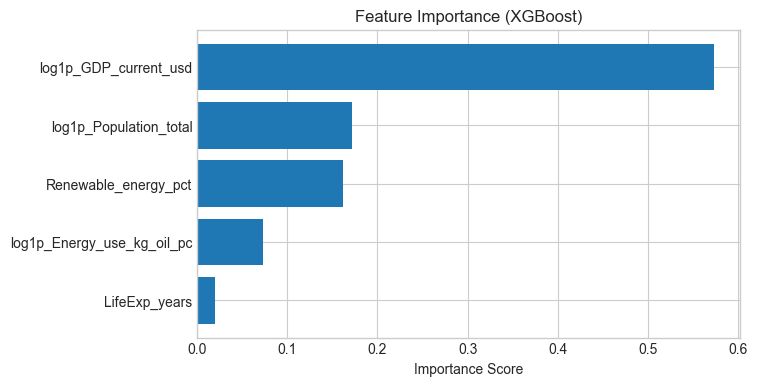

In [231]:
importance = pd.DataFrame({'Feature': features,'Importance': xgb.feature_importances_}).sort_values('Importance', ascending=False)
plt.figure(figsize=(7,4))
plt.barh(importance['Feature'], importance['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importance Score')
plt.show()

> **Tier-Aware Modeling (High / Medium / Low emitters)**

In [232]:
def build_tier_map(df, end_year, window=5):
    hist = df[df["Year"].between(end_year - window + 1, end_year)].dropna(subset=["CO2_total_mt"])
    if hist.empty:
        return {}
    mean_recent = hist.groupby("Country Code")["CO2_total_mt"].mean()
    q = mean_recent.quantile([0.33, 0.67]).values

    def assign(x):
        if x <= q[0]:
            return "Low"
        elif x <= q[1]:
            return "Medium"
        else:
            return "High"

    return mean_recent.apply(assign).to_dict()


def apply_tier(df, end_year):
    tier_map = build_tier_map(df, end_year=end_year, window=5)
    df_out = df.copy()
    df_out["Emission_Tier"] = df_out["Country Code"].map(tier_map)
    df_out["Emission_Tier"] = df_out["Emission_Tier"].fillna("Unlabeled")
    return df_out

tier_cutoff_year = 2014 if "CUTOFF_YEAR" not in globals() else max(int(CUTOFF_YEAR) - 1, df["Year"].min())
df = apply_tier(df, end_year=tier_cutoff_year)

print(f"Tier labels computed using data up to {tier_cutoff_year}")
print(df["Emission_Tier"].value_counts(dropna=False))


Tier labels computed using data up to 2014
Emission_Tier
Medium    2646
Low       2538
High      2538
Name: count, dtype: int64


In [233]:
for t in df["Emission_Tier"].unique():
    countries = df[df["Emission_Tier"]==t]["Country Name"].unique()
    print(f"\n{t} Tier ({len(countries)} countries):")
    print(", ".join(sorted(countries[:10])) + ("..." if len(countries) > 10 else ""))


Low Tier (47 countries):
Albania, Armenia, Benin, Botswana, Brunei Darussalam, Burkina Faso, Cambodia, Cameroon, Chad, Congo, Dem. Rep....

High Tier (47 countries):
Algeria, Argentina, Australia, Austria, Bangladesh, Belgium, Brazil, Canada, Chile, China...

Medium Tier (49 countries):
Angola, Azerbaijan, Bahrain, Belarus, Bolivia, Bosnia and Herzegovina, Bulgaria, Croatia, Cuba, Denmark...


In [234]:
features = ['log1p_GDP_current_usd','log1p_Population_total','log1p_Energy_use_kg_oil_pc','Renewable_energy_pct','LifeExp_years']
target = 'log1p_CO2_total_mt'
tiers = ['High', 'Medium', 'Low']
results = []

for t in tiers:
    df_t = df[df['Emission_Tier'] == t].dropna(subset=features + [target])
    
    train_t = df_t[df_t['Year'] <= 2015]
    test_t  = df_t[df_t['Year'] > 2015]

    X_train, y_train = train_t[features], train_t[target]
    X_test,  y_test  = test_t[features],  test_t[target]

    model = XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=5,subsample=0.8, colsample_bytree=0.8,reg_alpha=0.1, reg_lambda=1.0, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    results.append([t, rmse, r2])

tier_results = pd.DataFrame(results, columns=["Emission_Tier", "RMSE", "R2"])
print(tier_results)


  Emission_Tier      RMSE        R2
0          High  0.324859  0.913858
1        Medium  0.200053  0.859653
2           Low  0.298212  0.755900


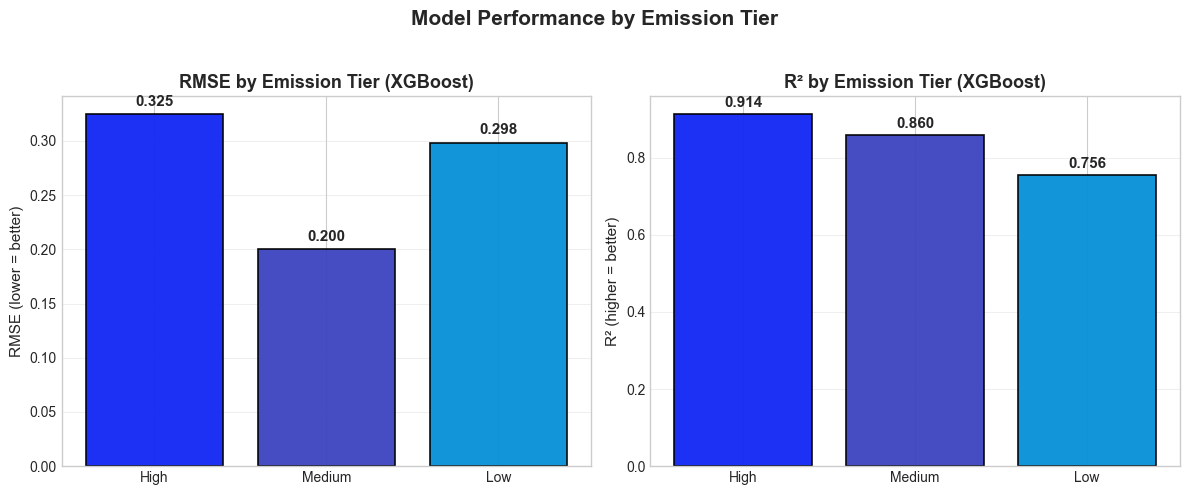

In [235]:
colors = ["#0F26F4", "#3C43BF", "#0691D7"]

fig, axes = plt.subplots(1, 2, figsize=(12,5))

bars1 = axes[0].bar(tier_results["Emission_Tier"],tier_results["RMSE"],color=colors,edgecolor="black",linewidth=1.2,alpha=0.95)
axes[0].set_title("RMSE by Emission Tier (XGBoost)", fontsize=13, weight='bold')
axes[0].set_ylabel("RMSE (lower = better)", fontsize=11)
axes[0].grid(alpha=0.3, axis='y')


for bar in bars1:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval + 0.005,f"{yval:.3f}", ha='center', va='bottom',fontsize=11, weight='bold')

bars2 = axes[1].bar(tier_results["Emission_Tier"],tier_results["R2"],color=colors,edgecolor="black",linewidth=1.2,alpha=0.95)
axes[1].set_title("R² by Emission Tier (XGBoost)", fontsize=13, weight='bold')
axes[1].set_ylabel("R² (higher = better)", fontsize=11)
axes[1].grid(alpha=0.3, axis='y')

for bar in bars2:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01,f"{yval:.3f}", ha='center', va='bottom',fontsize=11, weight='bold')

plt.suptitle("Model Performance by Emission Tier", fontsize=15, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


---- Feature importance: High Tier ----
                      Feature  Importance
4               LifeExp_years    0.033465
3        Renewable_energy_pct    0.079765
2  log1p_Energy_use_kg_oil_pc    0.177839
1      log1p_Population_total    0.241878
0       log1p_GDP_current_usd    0.467054

---- Feature importance: Medium Tier ----
                      Feature  Importance
4               LifeExp_years    0.040276
3        Renewable_energy_pct    0.122973
1      log1p_Population_total    0.176286
0       log1p_GDP_current_usd    0.203836
2  log1p_Energy_use_kg_oil_pc    0.456628

---- Feature importance: Low Tier ----
                      Feature  Importance
4               LifeExp_years    0.098848
2  log1p_Energy_use_kg_oil_pc    0.164776
1      log1p_Population_total    0.166220
0       log1p_GDP_current_usd    0.221434
3        Renewable_energy_pct    0.348722


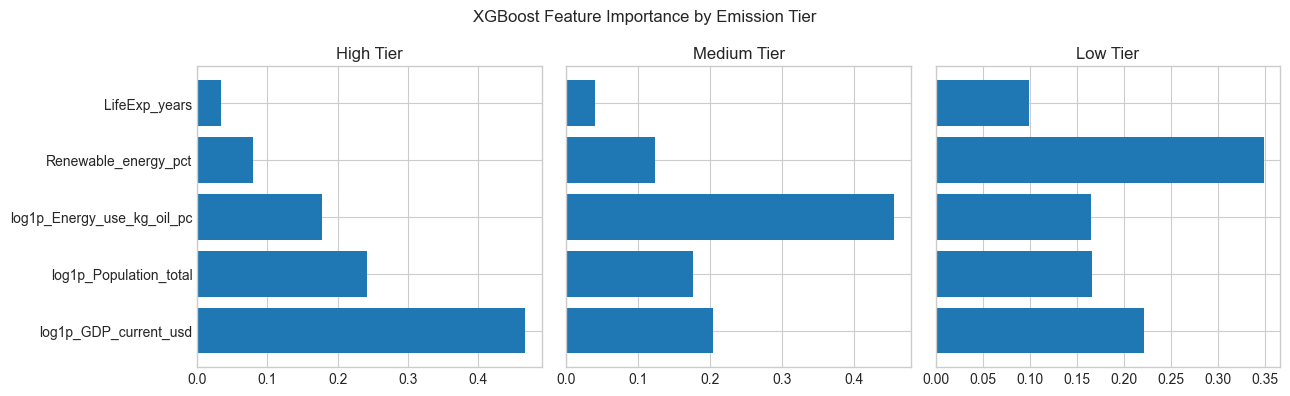

In [236]:
models_by_tier = {}
importances_by_tier = {}

for t in tiers:
    df_t = df[df['Emission_Tier'] == t].dropna(subset=features + [target])

    train_t = df_t[df_t['Year'] <= 2015]
    test_t  = df_t[df_t['Year'] > 2015]

    X_train, y_train = train_t[features], train_t[target]

    model = XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=5,subsample=0.8, colsample_bytree=0.8,reg_alpha=0.1, reg_lambda=1.0, random_state=42)
    model.fit(X_train, y_train)
    models_by_tier[t] = model  

    fi = pd.DataFrame({'Feature': features,'Importance': model.feature_importances_}).sort_values('Importance', ascending=True)

    importances_by_tier[t] = fi
    print(f"\n---- Feature importance: {t} Tier ----")
    print(fi)

fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
for ax, t in zip(axes, tiers):
    fi = importances_by_tier[t]
    ax.barh(fi['Feature'], fi['Importance'])
    ax.set_title(f'{t} Tier')
    ax.invert_yaxis()
plt.suptitle('XGBoost Feature Importance by Emission Tier')
plt.tight_layout()
plt.show()

> ### **Section 4: Forecast 2030 (Global & Tier-specific)**

In [237]:
LAST_YEAR = df["Year"].max() 

train_full = df[df["Year"] <= LAST_YEAR].dropna(subset=features+[target])
X_train_full = train_full[features]
y_train_full = train_full[target]

xgb_final = XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=5,subsample=0.8, colsample_bytree=0.8,reg_alpha=0.1, reg_lambda=1.0,random_state=42)
xgb_final.fit(X_train_full, y_train_full)

print("Final global XGB model trained up to year:", LAST_YEAR)

Final global XGB model trained up to year: 2023


In [238]:
LAST_YEAR = df["Year"].max()

feature_bounds = {col: (df[col].quantile(0.01), df[col].quantile(0.995)) for col in features}

def make_future_scenario(df, years_back=5, end_year=2030, bounds=None, renewable_step=0.0):
    rows = []
    bounds = bounds or {}
    tier_map_latest = build_tier_map(df, end_year=df["Year"].max(), window=5)

    for cc, g in df.groupby("Country Code"):
        g = g.sort_values("Year")
        country_name = g["Country Name"].iloc[-1]
        g_recent = g.tail(years_back)
        last_year = int(g_recent["Year"].iloc[-1])

        last_vals = {}
        slopes = {}
        for col in features:
            series = g_recent[["Year", col]].dropna()
            if series.empty:
                last_vals[col] = df[col].median()
                slopes[col] = 0.0
                continue
            y0 = series[col].iloc[0]
            y1 = series[col].iloc[-1]
            t0 = series["Year"].iloc[0]
            t1 = series["Year"].iloc[-1]
            slope = 0.0 if t1 == t0 else (y1 - y0) / (t1 - t0)
            last_vals[col] = y1
            slopes[col] = slope

        for y in range(last_year + 1, end_year + 1):
            step = y - last_year
            feat_vals = {}
            for col in features:
                val = last_vals[col] + slopes[col] * step
                if col == "Renewable_energy_pct":
                    val = val + renewable_step * step
                    val = max(0, min(100, val))
                lo, hi = bounds.get(col, (None, None))
                if lo is not None:
                    val = max(lo, val)
                if hi is not None:
                    val = min(hi, val)
                feat_vals[col] = val

            row = {
                "Country Code": cc,
                "Country Name": country_name,
                "Year": y,
                "Emission_Tier": tier_map_latest.get(cc, "Unlabeled"),
                **feat_vals,
            }
            rows.append(row)

    future_df = pd.DataFrame(rows)
    return future_df

future_features = make_future_scenario(df, years_back=10, end_year=2030, bounds=feature_bounds, renewable_step=0.0)
future_features.head()


,Country Code,Country Name,Year,Emission_Tier,log1p_GDP_current_usd,log1p_Population_total,log1p_Energy_use_kg_oil_pc,Renewable_energy_pct,LifeExp_years
0,AGO,Angola,2024,Medium,25.112061,17.453242,6.043897,53.5,65.086
1,AGO,Angola,2025,Medium,25.059675,17.486838,6.037772,54.1,65.555
2,AGO,Angola,2026,Medium,25.007290,17.520434,6.031646,54.7,66.024
3,AGO,Angola,2027,Medium,24.954904,17.554029,6.025521,55.3,66.493
4,AGO,Angola,2028,Medium,24.902518,17.587625,6.019395,55.9,66.962


In [239]:
future_features.describe()

,Year,log1p_GDP_current_usd,log1p_Population_total,log1p_Energy_use_kg_oil_pc,Renewable_energy_pct,LifeExp_years
count,1001.000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,2027.000,25.570496,16.509308,7.234148,31.356266,75.149547
std,2.001,1.739462,1.579763,0.996681,26.518315,6.316799
min,2024.000,21.448397,12.253269,5.094032,0.000000,54.742222
25%,2025.000,24.148151,15.516175,6.428134,10.877778,70.840333
50%,2027.000,25.351890,16.369552,7.286069,22.688889,75.983198
75%,2029.000,26.865422,17.554029,7.909653,48.633333,80.475889
max,2030.000,29.743380,20.940428,9.672218,96.600000,83.235049


In [240]:
X_future = future_features[features]
future_pred_log = xgb_final.predict(X_future)

train_pred_log = xgb_final.predict(X_train_full)
resid_var = np.var(y_train_full - train_pred_log, ddof=1)
resid_std = np.sqrt(resid_var)
bias_term = 0.5 * resid_var

future_features["pred_log1p_CO2_total_mt"] = future_pred_log
future_features["pred_CO2_total_mt_mean"] = np.expm1(future_pred_log + bias_term).clip(min=0)
future_features["pred_CO2_total_mt_p05"] = np.expm1(future_pred_log - 1.645 * resid_std).clip(min=0)
future_features["pred_CO2_total_mt_p95"] = np.expm1(future_pred_log + 1.645 * resid_std).clip(min=0)

future_features.head()


,Country Code,Country Name,Year,Emission_Tier,log1p_GDP_current_usd,log1p_Population_total,log1p_Energy_use_kg_oil_pc,Renewable_energy_pct,LifeExp_years,pred_log1p_CO2_total_mt,pred_CO2_total_mt_mean,pred_CO2_total_mt_p05,pred_CO2_total_mt_p95
0,AGO,Angola,2024,Medium,25.112061,17.453242,6.043897,53.5,65.086,3.506581,32.545780,26.701563,39.111889
1,AGO,Angola,2025,Medium,25.059675,17.486838,6.037772,54.1,65.555,3.517905,32.927818,27.017044,39.568707
2,AGO,Angola,2026,Medium,25.007290,17.520434,6.031646,54.7,66.024,3.512199,32.734776,26.857632,39.337875
3,AGO,Angola,2027,Medium,24.954904,17.554029,6.025521,55.3,66.493,3.509074,32.629528,26.770720,39.212029
4,AGO,Angola,2028,Medium,24.902518,17.587625,6.019395,55.9,66.962,3.543753,33.816204,27.750660,40.630981


In [241]:
actual = df[["Country Code", "Country Name", "Year", "Emission_Tier", "CO2_total_mt"]].copy()
actual["Source"] = "Actual"

forecast = future_features[["Country Code", "Country Name", "Year", "Emission_Tier", "pred_CO2_total_mt_mean"]].rename(columns={"pred_CO2_total_mt_mean": "CO2_total_mt"})
forecast["Source"] = "Forecast"

combined = pd.concat([actual, forecast], ignore_index=True)


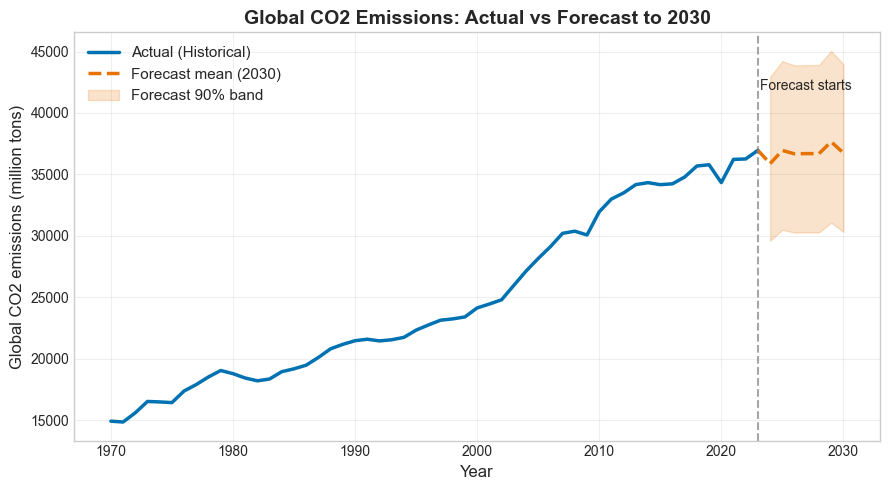

In [242]:
world_series = combined.groupby(["Year", "Source"])["CO2_total_mt"].sum().reset_index()
world_bounds = (future_features.groupby("Year")[ ["pred_CO2_total_mt_p05", "pred_CO2_total_mt_p95"] ]
                                .sum()
                                .reset_index())

plt.figure(figsize=(9,5))
world_actual = world_series[world_series["Source"] == "Actual"].sort_values("Year")
world_forecast = world_series[world_series["Source"] == "Forecast"].sort_values("Year")

plt.plot(world_actual["Year"], world_actual["CO2_total_mt"], label="Actual (Historical)", color="#0072B2", linewidth=2.5)
plt.plot(world_forecast["Year"], world_forecast["CO2_total_mt"], "--", label="Forecast mean (2030)", color="#E67300", linewidth=2.5)

# bridge last actual -> first forecast so the lines connect visually
if not world_actual.empty and not world_forecast.empty:
    plt.plot(
        [world_actual["Year"].iloc[-1], world_forecast["Year"].iloc[0]],
        [world_actual["CO2_total_mt"].iloc[-1], world_forecast["CO2_total_mt"].iloc[0]],
        color="#E67300", linestyle="--", linewidth=2.5)

if not world_bounds.empty:
    plt.fill_between(world_bounds["Year"], world_bounds["pred_CO2_total_mt_p05"], world_bounds["pred_CO2_total_mt_p95"],
                     color="#E67300", alpha=0.2, label="Forecast 90% band")

plt.axvline(LAST_YEAR, color="gray", linestyle="--", alpha=0.7)
plt.text(LAST_YEAR + 0.2, plt.ylim()[1] * 0.90, "Forecast starts")

plt.xlabel("Year", fontsize=12)
plt.ylabel("Global CO2 emissions (million tons)", fontsize=12)
plt.title("Global CO2 Emissions: Actual vs Forecast to 2030", fontsize=14, weight="bold")
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [243]:
world_forecast

,Year,Source,CO2_total_mt
54,2024,Forecast,35876.607791
55,2025,Forecast,36948.920878
56,2026,Forecast,36671.354806
57,2027,Forecast,36692.207080
58,2028,Forecast,36685.449751
59,2029,Forecast,37655.127703
60,2030,Forecast,36742.867260


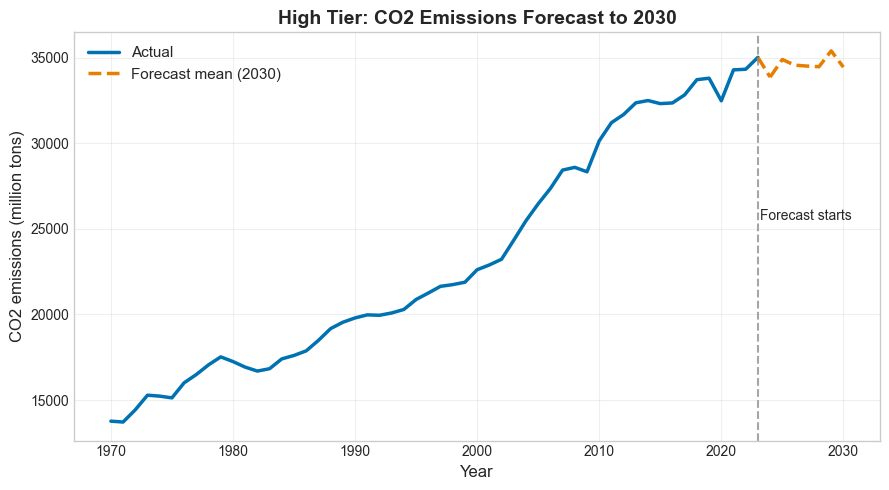

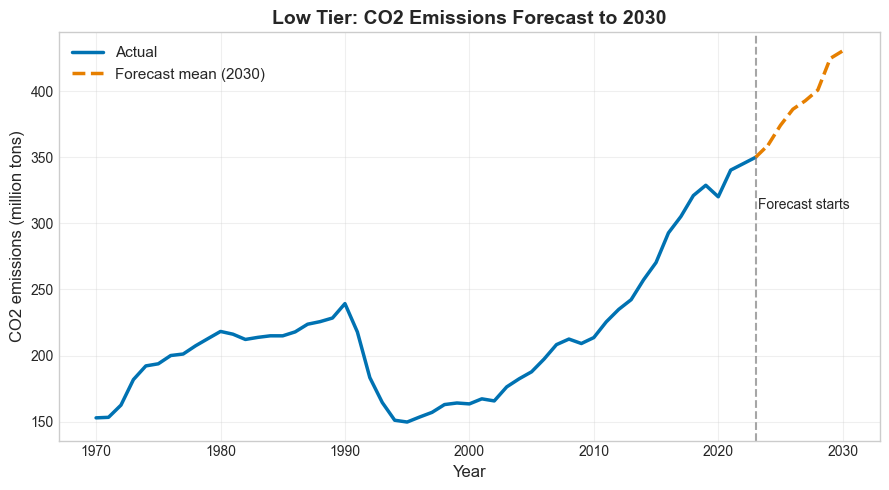

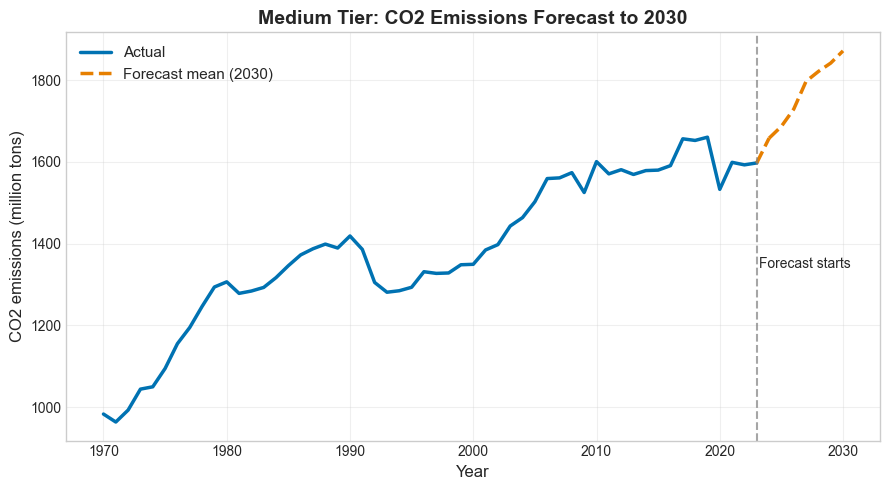

In [244]:
tier_series = (combined.groupby(["Year", "Emission_Tier", "Source"])["CO2_total_mt"]
                             .sum()
                             .reset_index())

for t in sorted(tier_series["Emission_Tier"].dropna().unique()):
    data_t = tier_series[tier_series["Emission_Tier"] == t]
    act_t  = data_t[data_t["Source"] == "Actual"]
    fc_t   = data_t[data_t["Source"] == "Forecast"]

    plt.figure(figsize=(9,5))
    plt.plot(act_t["Year"], act_t["CO2_total_mt"], label="Actual", color="#0072B2", linewidth=2.5)
    plt.plot(fc_t["Year"], fc_t["CO2_total_mt"], "--", label="Forecast mean (2030)", color="#E67F00", linewidth=2.5)

    if not act_t.empty and not fc_t.empty:
        plt.plot([act_t["Year"].iloc[-1], fc_t["Year"].iloc[0]], [act_t["CO2_total_mt"].iloc[-1], fc_t["CO2_total_mt"].iloc[0]],
                 color="#E67F00", linestyle="--", linewidth=2.5)

    plt.axvline(LAST_YEAR, color="gray", linestyle="--", alpha=0.7)
    plt.text(LAST_YEAR + 0.2, plt.ylim()[1] * 0.70, "Forecast starts")

    plt.title(f"{t} Tier: CO2 Emissions Forecast to 2030", fontsize=14, weight="bold")
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("CO2 emissions (million tons)", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


## Findings & Limitations
- **Model ranking:** XGBoost and RF remain best-performing in panel time-series CV (H=1?5), while ARIMA baselines are weak; ARIMAX improves for a subset of countries when exogenous signals exist.
- **Data leakage mitigated:** Emission tiers now computed pre-2015; CV uses future horizons only.
- **Forecast caveats:** Future scenarios are linear/bounded; results are sensitive to scenario settings and capped feature growth.
- **Uncertainty:** Bias-corrected log back-transform with 90% bands included; no stochastic driver simulation yet.
- **Next steps:** Tune horizons/params, add alternative scenarios (e.g., high-renewable vs BAU), and broaden ARIMAX/SARIMAX search for robustness.
